In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -qr yolov5/requirements.txt

In [ ]:
import os
import shutil
import gdown
import random
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
from collections import Counter
from xml.etree import ElementTree
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image, Video
from ultralytics import YOLO

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
annot_data_path = '/content/DIOR/Annotations/Horizontal'
trainval_data_path = '/content/DIOR/train'
test_data_path = '/content/DIOR/test_images'

In [ ]:
annot_file_list = sorted([os.path.join(annot_data_path, i) for i in os.listdir(annot_data_path) if '.xml' in i])
annot_file_list[:5], annot_file_list[-5:], len(annot_file_list)

In [ ]:
trainval_file_list = sorted([os.path.join(trainval_data_path, i) for i in os.listdir(trainval_data_path) if '.jpg' in i])
trainval_file_list[:5], trainval_file_list[-5:], len(trainval_file_list)

In [ ]:
test_file_list = sorted([os.path.join(test_data_path, i) for i in os.listdir(test_data_path) if '.jpg' in i])
test_file_list[:5], test_file_list[-5:], len(test_file_list)

In [ ]:
image_data_file_list = np.concatenate((trainval_file_list, test_file_list))
image_data_file_list[:5], image_data_file_list[-5:], len(image_data_file_list)

In [ ]:
meta_list = []
object_list_train = []
object_list_test = []

for file in tqdm(annot_file_list):
    meta_dict = {}
    root = ElementTree.parse(file).getroot()

    for path in image_data_file_list:
        if root.find('filename').text in path:
            meta_dict['filename'] = path
            meta_dict['split_type'] = path.split('/')[3]

    meta_dict['width'] = int(root.find('size').find('width').text)
    meta_dict['height'] = int(root.find('size').find('height').text)
    meta_dict['objects'] = ', '.join(np.unique([obj.find('name').text for obj in root.findall('object')]))
    meta_list.append(meta_dict)

    for obj in root.findall('object'):
        if meta_dict['split_type'] == 'train':
            object_list_train.append(obj.find('name').text)
        elif meta_dict['split_type'] == 'test_images':
            object_list_test.append(obj.find('name').text)

object_instance_list_train = Counter(sorted(object_list_train))
object_instance_list_test = Counter(sorted(object_list_test))

class_dict = {k: v for v, k in enumerate(sorted(np.unique(object_list_train)))}
meta_list[:5], object_instance_list_train, object_instance_list_test, class_dict

In [ ]:
meta_df = pd.DataFrame(meta_list)
meta_df

filename   split_type  width  height  \
0            /content/DIOR/train/00001.jpg        train    800     800   
1            /content/DIOR/train/00002.jpg        train    800     800   
2            /content/DIOR/train/00003.jpg        train    800     800   
3            /content/DIOR/train/00004.jpg        train    800     800   
4            /content/DIOR/train/00005.jpg        train    800     800   
...                                    ...          ...    ...     ...   
23458  /content/DIOR/test_images/23459.jpg  test_images    800     800   
23459  /content/DIOR/test_images/23460.jpg  test_images    800     800   
23460  /content/DIOR/test_images/23461.jpg  test_images    800     800   
23461  /content/DIOR/test_images/23462.jpg  test_images    800     800   
23462  /content/DIOR/test_images/23463.jpg  test_images    800     800   

                                      objects  
0                                   golffield  
1            Expressway-toll-station, vehicle  
2                                trainstation  
3                                     chimney  
4                        storagetank, vehicle  
...                                       ...  
23458                                 vehicle  
23459  groundtrackfield, tenniscourt, vehicle  
23460                       overpass, vehicle  
23461                       overpass, vehicle  
23462                       overpass, vehicle  

[23463 rows x 5 columns]

In [ ]:
print(f'Size of the images width: {meta_df.width.unique()[0]} and height: {meta_df.height.unique()[0]}')
print(f'Total number of classes with all possible combination: {len(meta_df.objects.unique())}')
print(f'Total length of the training/validation dataset: {len(meta_df[meta_df["split_type"] == "train"])} and testing dataset: {len(meta_df[meta_df["split_type"] == "test_images"])}')

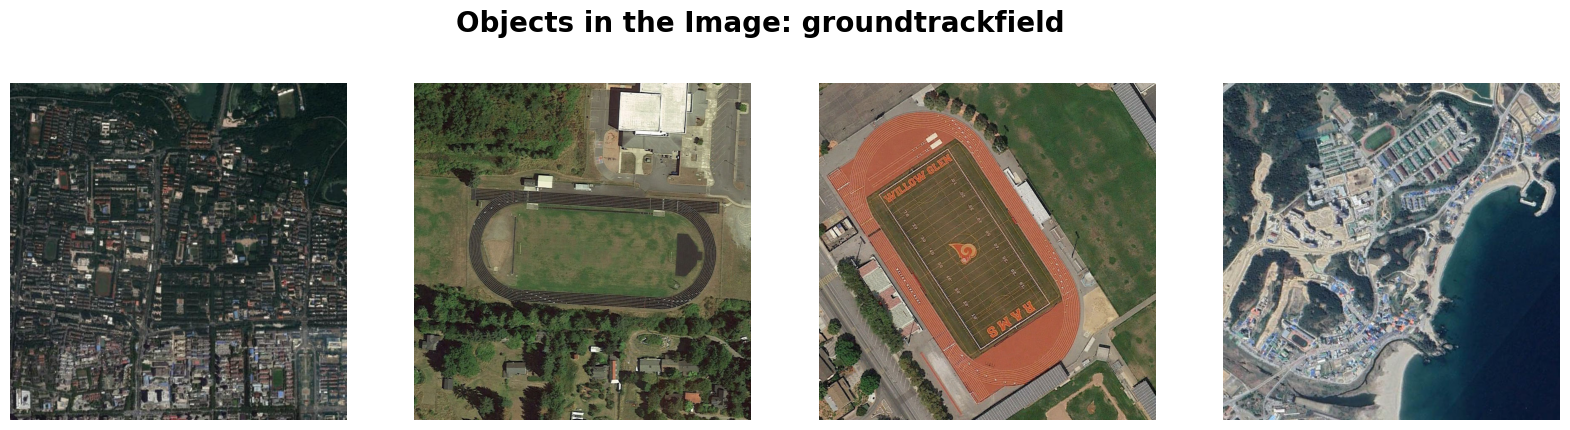

In [ ]:
viz_class = random.sample(meta_df.objects.tolist(), 1)[0]
viz_list = meta_df[meta_df['objects'] == viz_class].filename.tolist()
plt.figure(figsize=(20, 5))
rand = random.sample(viz_list, 4)
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(plt.imread(rand[i]))
    plt.suptitle(f'Objects in the Image: {viz_class}', fontsize=20, fontweight='bold')
    plt.axis(False)

In [ ]:
def extract_data_from_xml(xml_file: str):

    root = ElementTree.parse(xml_file).getroot()
    data_dict = {}
    data_dict['bboxes'] = []

    for element in root:
        if element.tag == 'filename':
            data_dict['filename'] = element.text
        elif element.tag == 'size':
            image_size = []
            for size_element in element:
                image_size.append(int(size_element.text))
            data_dict['image_size'] = image_size
        elif element.tag == 'object':
            bbox = {}
            for obj_element in element:
                if obj_element.tag == 'name':
                    bbox['class'] = obj_element.text
                elif obj_element.tag == 'bndbox':
                    for bbox_element in obj_element:
                        bbox[bbox_element.tag] = int(bbox_element.text)
            data_dict['bboxes'].append(bbox)
    return data_dict

In [ ]:
example = extract_data_from_xml(annot_file_list[1])
example

In [ ]:
def convert_dict_to_yolo(data_dict: dict):

    data = []

    for bbox in data_dict['bboxes']:
        try:
            class_id = class_dict[bbox['class']]
        except KeyError:
            print(f'Invalid Class. Object class: "{bbox["class"]}" not present in the class list.')

        img_w, img_h, _ = data_dict['image_size']

        x_center = ((bbox['xmin'] + bbox['xmax']) / 2) / img_w
        y_center = ((bbox['ymin'] + bbox['ymax']) / 2) / img_h
        width = (bbox['xmax'] - bbox['xmin']) / img_w
        height = (bbox['ymax'] - bbox['ymin']) / img_h
        data.append(f'{class_id} {x_center:.3f} {y_center:.3f} {width:.3f} {height:.3f}')

    yolo_annot_dir = os.path.join('dior_data', 'yolo_annotations')
    if not os.path.exists(yolo_annot_dir):
        os.makedirs(yolo_annot_dir)
    save_file_name = os.path.join(yolo_annot_dir, data_dict['filename'].replace('jpg', 'txt'))

    f = open(save_file_name, 'w+')
    f.write('\n'.join(data))
    f.close()

In [ ]:
for annot_file in tqdm(annot_file_list):
    data_dict = extract_data_from_xml(annot_file)
    convert_dict_to_yolo(data_dict)
print('[INFO] All the annotation are converted into Yolo format.')

In [ ]:
yolo_annot_path = '/content/dior_data/yolo_annotations'
yolo_annot_file_list = sorted([os.path.join(yolo_annot_path, i) for i in os.listdir(yolo_annot_path) if '.txt' in i])
yolo_annot_file_list[:5], yolo_annot_file_list[-5:], len(yolo_annot_file_list)

In [ ]:
class_dict_idx = dict(zip(class_dict.values(), class_dict.keys()))
class_dict_idx

In [ ]:
def plot_bboxes(img_file: str, annot_file: str, class_dict: dict):

    image = cv2.imread(img_file)
    img_h, img_w, _ = image.shape

    with open(annot_file, 'r') as f:
        data = f.read().split('\n')
        data = [i.split(' ') for i in data]
        data = [[float(j) for j in i] for i in data]

    for bbox in data:
        class_idx, x_center, y_center, width, height = bbox
        xmin = int((x_center - width / 2) * img_w)
        ymin = int((y_center - height / 2) * img_h)
        xmax = int((x_center + width / 2) * img_w)
        ymax = int((y_center + height / 2) * img_h)

        if xmin < 0:
            xmin = 0
        if ymin < 0:
            ymin = 0
        if xmax > img_w - 1:
            xmax = img_w - 1
        if ymax > img_h - 1:
            ymax = img_h - 1

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 255, 0), 2)
        cv2.putText(image, class_dict[class_idx], (xmin, 0 if ymin-10 < 0 else ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)

    plt.imshow(image)
    plt.axis(False)

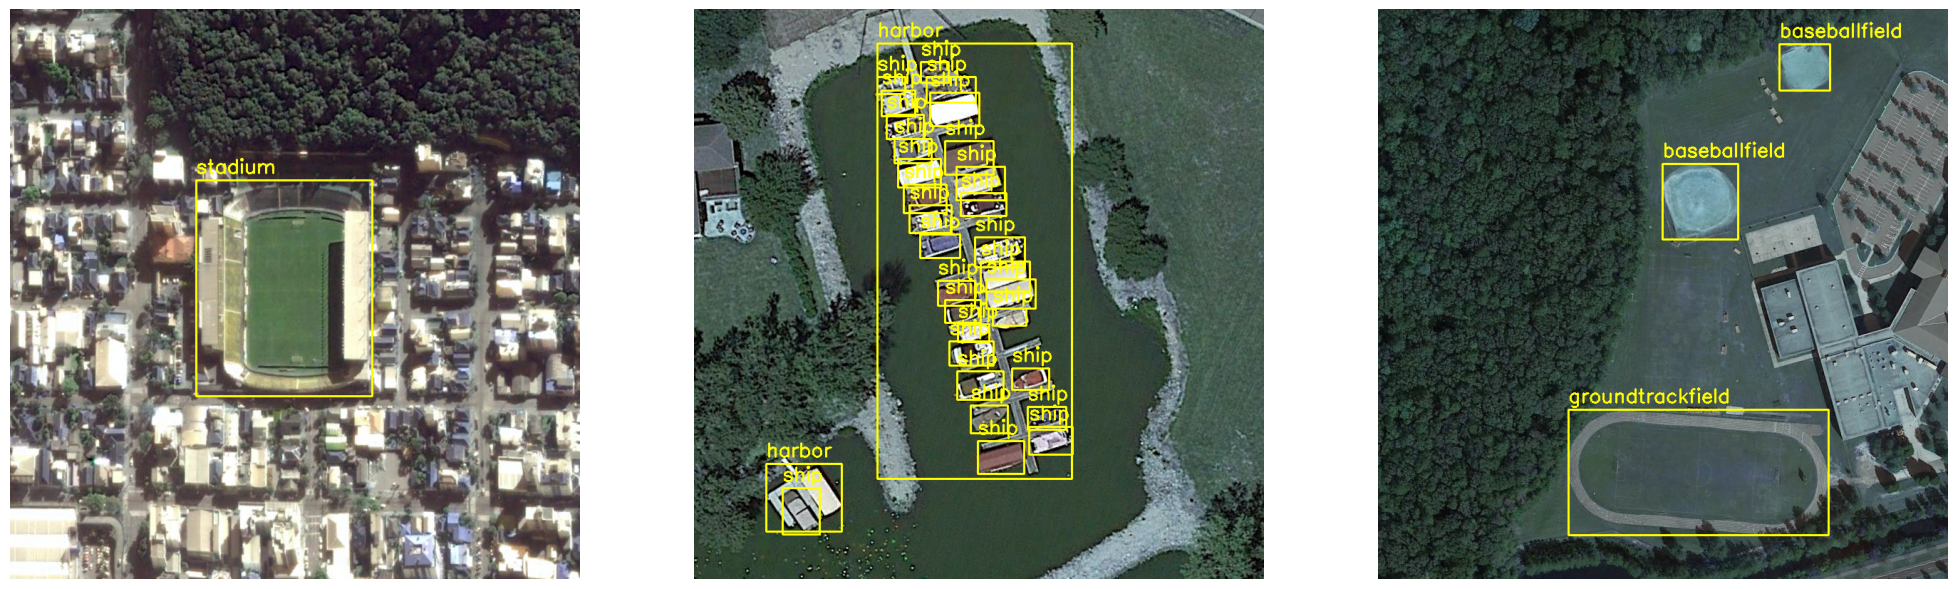

In [ ]:
plt.figure(figsize=(25, 8))
rand_int = random.sample(range(len(yolo_annot_file_list)), 3)
for i in range(3):
    plt.subplot(1, 3, i+1)
    plot_bboxes(image_data_file_list[rand_int[i]], yolo_annot_file_list[rand_int[i]], class_dict_idx)

In [ ]:
root_dir = '/content/dior_data/datasets'
image_dir = '/content/dior_data/datasets/images'
label_dir = '/content/dior_data/datasets/labels'
img_train_dir = '/content/dior_data/datasets/images/train'
img_val_dir = '/content/dior_data/datasets/images/val'
label_train_dir = '/content/dior_data/datasets/labels/train'
label_val_dir = '/content/dior_data/datasets/labels/val'

total_val_size = int(len(test_file_list) * 0.5)
total_val_size

2295

In [ ]:
if not os.path.exists(img_train_dir):
    os.makedirs(img_train_dir)
for filepath in tqdm(trainval_file_list):
    if os.path.isfile(filepath):
        shutil.copy(filepath, img_train_dir)

In [ ]:
if not os.path.exists(img_val_dir):
    os.makedirs(img_val_dir)

for filepath in tqdm(test_file_list[:total_val_size]):
    if os.path.isfile(filepath):
        shutil.copy(filepath, img_val_dir)

In [ ]:
if not os.path.exists(label_train_dir):
    os.makedirs(label_train_dir)

for filepath in tqdm(trainval_file_list):
    file_path = os.path.join('dior_data/yolo_annotations', filepath.replace('jpg', 'txt').split('/')[-1])
    if os.path.isfile(file_path):
        shutil.move(file_path, label_train_dir)

In [ ]:
if not os.path.exists(label_val_dir):
    os.makedirs(label_val_dir)

for filepath in tqdm(test_file_list[:total_val_size]):
    file_path = os.path.join('dior_data/yolo_annotations', filepath.replace('jpg', 'txt').split('/')[-1])
    if os.path.isfile(file_path):
        shutil.move(file_path, label_val_dir)

In [ ]:
%%writefile config.yaml

path:
train: '/content/drive/MyDrive/test_cam/images/train'
val: '/content/drive/MyDrive/test_cam/images/val'

names:
  0: Expressway-Service-area
  1: Expressway-toll-station
  2: airplane
  3: airport
  4: baseballfield
  5: basketballcourt
  6: bridge
  7: chimney
  8: dam
  9: golffield
  10: groundtrackfield
  11: harbor
  12: overpass
  13: ship
  14: stadium
  15: storagetank
  16: tenniscourt
  17: trainstation
  18: vehicle
  19: windmill

Writing config.yaml


In [ ]:
!pip install -q wandb
import wandb
wandb.login()
!wandb enabled

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 28.3 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

In [ ]:
!python /content/yolov5/train.py --data /content/config.yaml --cfg yolov5x.yaml --weights yolov5x.pt --imgsz 800 --epochs 50 --batch 16

In [ ]:
img_test_dir = '/content/dior_data/datasets/images/test'

if not os.path.exists(img_test_dir):
    os.makedirs(img_test_dir)

test_list = os.listdir('/content/DIOR/test_images')
for filename in tqdm(test_list):
    filepath = os.path.join('/content/DIOR/test_images', filename)
    if os.path.isfile(filepath):
        shutil.copy(filepath, img_test_dir)

In [ ]:
label_test_dir = '/content/dior_data/datasets/labels/test'

if not os.path.exists(label_test_dir):
    os.makedirs(label_test_dir)

for filename in tqdm(test_list):
    filepath = os.path.join('dior_data/yolo_annotations', filename).replace('jpg', 'txt')
    if os.path.isfile(filepath):
        shutil.move(filepath, label_test_dir)

In [ ]:
%%writefile test_config.yaml

path:
train:
val: '/content/drive/MyDrive/test_cam/images/cam'
names:
  0: Expressway-Service-area
  1: Expressway-toll-station
  2: airplane
  3: airport
  4: baseballfield
  5: basketballcourt
  6: bridge
  7: chimney
  8: dam
  9: golffield
  10: groundtrackfield
  11: harbor
  12: overpass
  13: ship
  14: stadium
  15: storagetank
  16: tenniscourt
  17: trainstation
  18: vehicle
  19: windmill

In [ ]:
!python /content/yolov5/val.py --data /content/test_config.yaml --weights /content/drive/MyDrive/best.pt --task val --imgsz 800 --iou-thres 0.1

In [ ]:
model = YOLO('/content/runs/detect/yolov5x_train/weights/best.pt')

img_test_dir = '/content/dior_data/datasets/images/test'
label_test_dir = '/content/dior_data/datasets/labels/test'
rand_img = random.sample(os.listdir(img_test_dir), 1)[0]
rand_img_path = os.path.join(img_test_dir, rand_img)
rand_label_path = os.path.join(label_test_dir, rand_img).replace('jpg', 'txt')

pred_list = model.predict(source=rand_img_path, imgsz=800, save=True, conf=0.5)
pred_img_path = os.path.join('/content/runs/detect/predict10', rand_img)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plot_bboxes(rand_img_path, rand_label_path, class_dict_idx)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(pred_img_path))
plt.title('Predicted Image')
plt.axis(False);